In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

In [27]:
def load_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

ticker = 'AAPL'  # Change to the ticker of your choice
start_date = '2015-01-01'
end_date = '2022-12-31'
data = load_stock_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [28]:
# Step 2: Feature engineering
data['Day'] = data.index.dayofweek
rolling_window = 7
data['RollingMean'] = data['Close'].rolling(window=rolling_window).mean()
data['RollingStd'] = data['Close'].rolling(window=rolling_window).std()
data.dropna(inplace=True)


In [29]:
# Step 3: Preprocess data
def preprocess_data(data, feature_columns, target_column):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(data[feature_columns])
    scaled_target = scaler.fit_transform(data[[target_column]])
    return scaled_features, scaled_target, scaler

feature_columns = ['Close', 'Day', 'RollingMean', 'RollingStd']
target_column = 'Close'
scaled_features, scaled_target, scaler = preprocess_data(data, feature_columns, target_column)

In [30]:
# Step 4: Create sequences
def create_sequences(features, target, time_step):
    x, y = [], []
    for i in range(len(features) - time_step - 1):
        x.append(features[i:(i + time_step)])
        y.append(target[i + time_step])
    return np.array(x), np.array(y)

time_step = 60
x, y = create_sequences(scaled_features, scaled_target, time_step)


In [31]:
# Step 5: Split data into training, validation, and testing
train_size = int(len(x) * 0.8)
x_train_full, x_test = x[:train_size], x[train_size:]
y_train_full, y_test = y[:train_size], y[train_size:]

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)


In [32]:
# Step 6: Build LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(50),
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# Step 7: Compile and train model
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0187 - val_loss: 5.1832e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0018 - val_loss: 2.5435e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 9.4562e-04 - val_loss: 3.3504e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 9.9816e-04 - val_loss: 4.2600e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 9.0443e-04 - val_loss: 4.0780e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 8.9730e-04 - val_loss: 5.6785e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 6.8399e-04 - val_loss: 3.4678e-04


In [34]:
# Step 8: Make predictions
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)
test_predict = model.predict(x_test)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [35]:
# Step 9: Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
val_predict = scaler.inverse_transform(val_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_val = scaler.inverse_transform(y_val)
y_test = scaler.inverse_transform(y_test)


In [36]:
# Step 10: Validate model accuracy
train_mse = mean_squared_error(y_train, train_predict)
val_mse = mean_squared_error(y_val, val_predict)
test_mse = mean_squared_error(y_test, test_predict)
train_mae = mean_absolute_error(y_train, train_predict)
val_mae = mean_absolute_error(y_val, val_predict)
test_mae = mean_absolute_error(y_test, test_predict)

print("Training MSE:", train_mse)
print("Validation MSE:", val_mse)
print("Testing MSE:", test_mse)
print("Training MAE:", train_mae)
print("Validation MAE:", val_mae)
print("Testing MAE:", test_mae)


Training MSE: 8.346074670085285
Validation MSE: 6.3801708673678235
Testing MSE: 41.15977495690917
Training MAE: 1.8417992833149
Validation MAE: 1.635958035786946
Testing MAE: 5.24320103571965


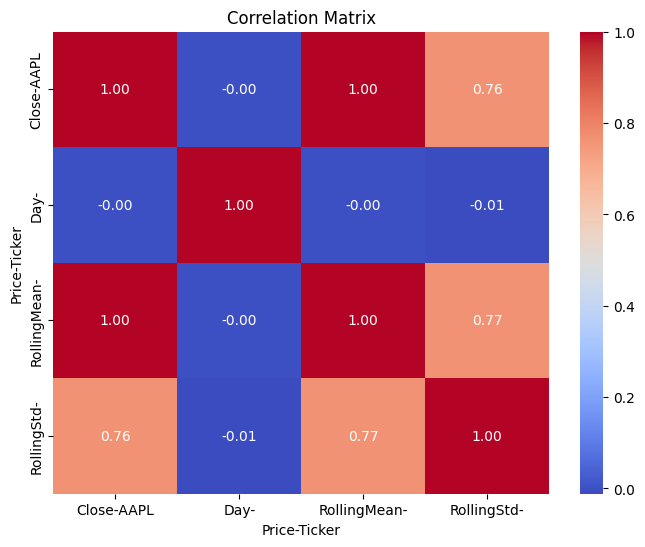

In [37]:
# Step 11: Plot correlation matrix
correlation_matrix = data[['Close', 'Day', 'RollingMean', 'RollingStd']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


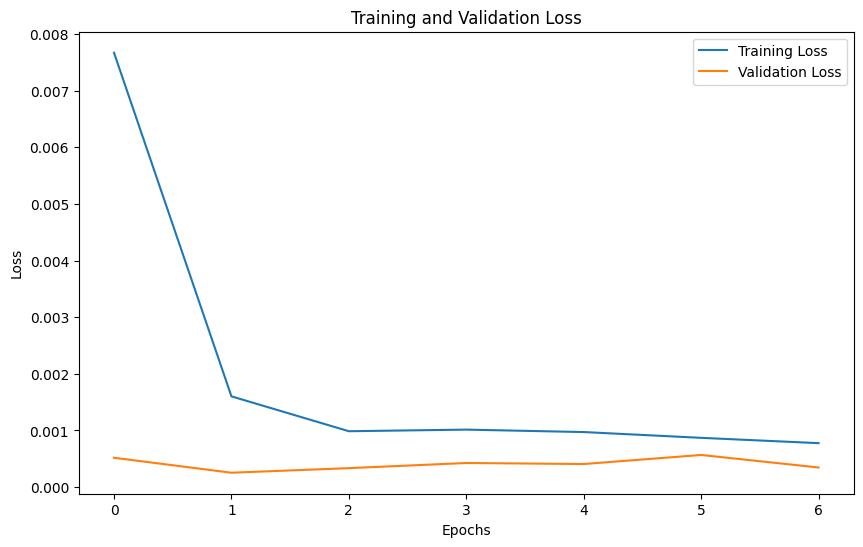

In [38]:
# Step 12: Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


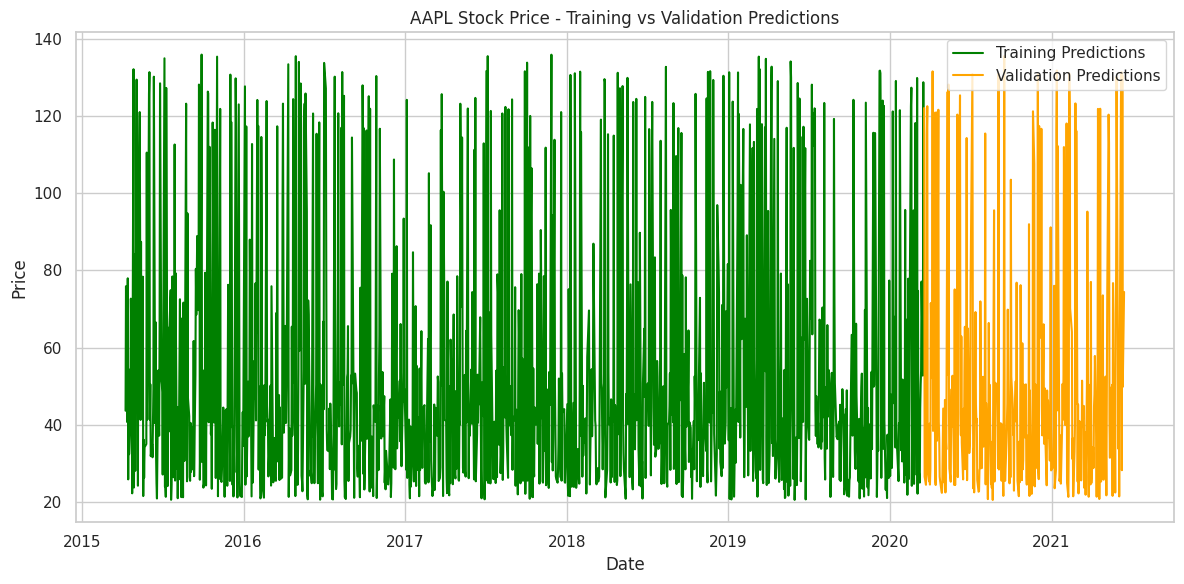

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for better visuals
sns.set(style="whitegrid", palette="muted")

# Step 13: Plot Training vs Validation Predictions
plt.figure(figsize=(12, 6))

# Plot training and validation predictions using seaborn's lineplot
sns.lineplot(x=data.index[train_range], y=train_predict.flatten(), label='Training Predictions', color='green')
sns.lineplot(x=data.index[val_range], y=val_predict.flatten(), label='Validation Predictions', color='orange')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title(f'{ticker} Stock Price - Training vs Validation Predictions')

plt.tight_layout()
plt.show()


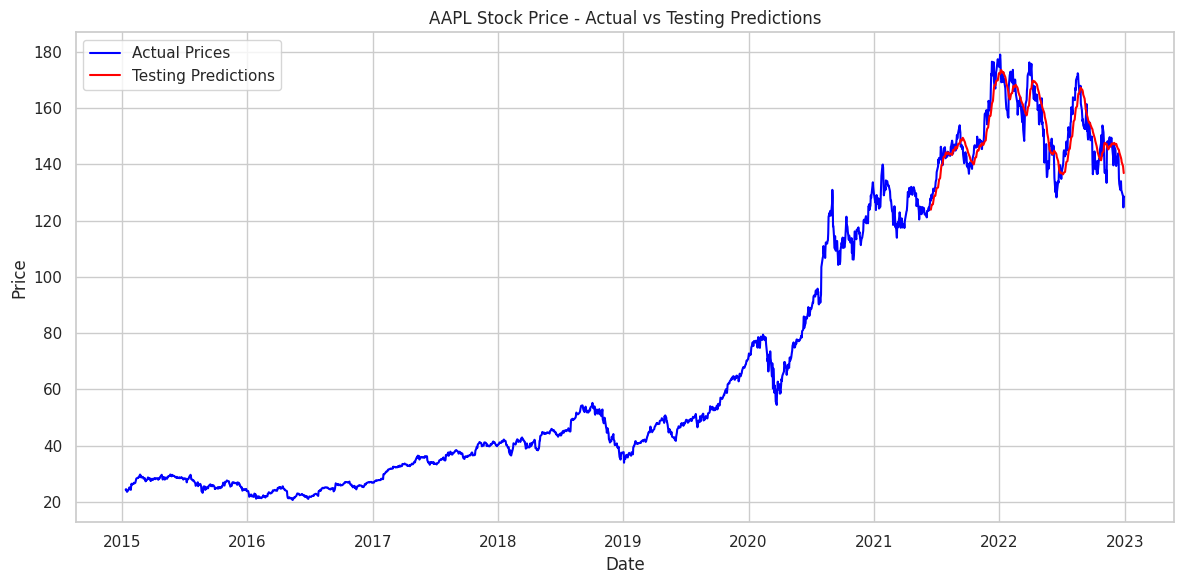

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for better visuals
sns.set(style="whitegrid", palette="muted")

# Step 14: Plot Actual vs Testing Predictions
plt.figure(figsize=(12, 6))

# Plot actual vs testing predictions
sns.lineplot(x=data.index, y=data['Close'].values.flatten(), label='Actual Prices', color='blue')
sns.lineplot(x=data.index[test_range], y=test_predict.flatten(), label='Testing Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title(f'{ticker} Stock Price - Actual vs Testing Predictions')

plt.tight_layout()
plt.show()
